Data Collection & Preprocessing

1. Downloading the data from the link provided in Readme. 
2. The Training data is analysed and preprocessing is done.
3. After preprocessing the network is trained using the training data.

In [3]:
# importing dependencies
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import struct
from xml.dom import minidom
from xml.etree import ElementTree as eltree
import pandas as pd
from tqdm import tqdm
from shutil import copyfile
from PIL import Image, ImageDraw
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, Dropout, Layer, UpSampling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.applications import VGG19
import pytesseract
from graphviz import *

In [4]:
data_dir = os.path.join('data', 'C:\\Users\\AkshayPatil\\Desktop\\Falcon\\PDF_OCR\\dataset\\marmot_dataset_v1.0')
os.listdir(data_dir)

['copyright.txt',
 'data',
 'Layout Description Schema for Marmot.pdf',
 'xml_schema']

In [5]:
data_dir = os.path.join(data_dir, 'data')
os.listdir(data_dir)

['Chinese', 'English']

In [6]:
print(os.listdir(os.path.join(data_dir, 'English')))

['Negative', 'Positive']


In [7]:
# exploring the english subdirectory
english_data_dir = os.path.join(data_dir, 'English')
print('Contents of the English subdirectory : ')
print(os.listdir(english_data_dir))
print()
print('Contents of the positive subdirectory : ')
print(os.listdir(os.path.join(english_data_dir, 'positive')))
print()
print('Contents of the negative subdirectory : ')
print(os.listdir(os.path.join(english_data_dir, 'negative')))

Contents of the English subdirectory : 
['Negative', 'Positive']

Contents of the positive subdirectory : 
['Labeled', 'Raw']

Contents of the negative subdirectory : 
['Labeled', 'Raw']


In [8]:
print("Number of files in Positive/Raw : ", len(os.listdir(os.path.join(english_data_dir, 'Positive', 'Raw'))))
print()
print("Some contents of the Positive/Raw directory :")
os.listdir(os.path.join(english_data_dir, 'Positive', 'Raw'))[:10]

Number of files in Positive/Raw :  1018

Some contents of the Positive/Raw directory :


['10.1.1.1.2006_3.bmp',
 '10.1.1.1.2006_3_phy.xml',
 '10.1.1.1.2010_5.bmp',
 '10.1.1.1.2010_5_phy.xml',
 '10.1.1.1.2013_63.bmp',
 '10.1.1.1.2013_63_phy.xml',
 '10.1.1.1.2013_64.bmp',
 '10.1.1.1.2013_64_phy.xml',
 '10.1.1.1.2014_4.bmp',
 '10.1.1.1.2014_4_phy.xml']

In [9]:
bmp_files = [f for f in os.listdir(os.path.join(english_data_dir, 'Positive', 'Raw')) if f.endswith('bmp')]
xml_raw_files = [f for f in os.listdir(os.path.join(english_data_dir, 'Positive', 'Raw')) if f.endswith('xml')]
print("Number of .bmp files (Positive): ", len(bmp_files))
print("Number of raw .xml files (Positive) : ", len(xml_raw_files))

Number of .bmp files (Positive):  509
Number of raw .xml files (Positive) :  509


In [10]:
print("Number of files in Positive/Labeled : ", len(os.listdir(os.path.join(english_data_dir, 'Positive', 'Labeled'))))
print()
print("Some contents of the Positive/Labeled directory :")
os.listdir(os.path.join(english_data_dir, 'Positive', 'Labeled'))[:10]

Number of files in Positive/Labeled :  509

Some contents of the Positive/Labeled directory :


['10.1.1.1.2006_3.xml',
 '10.1.1.1.2010_5.xml',
 '10.1.1.1.2013_63.xml',
 '10.1.1.1.2013_64.xml',
 '10.1.1.1.2014_4.xml',
 '10.1.1.1.2014_6.xml',
 '10.1.1.1.2018_4.xml',
 '10.1.1.1.2018_8.xml',
 '10.1.1.1.2019_2.xml',
 '10.1.1.1.2019_3.xml']

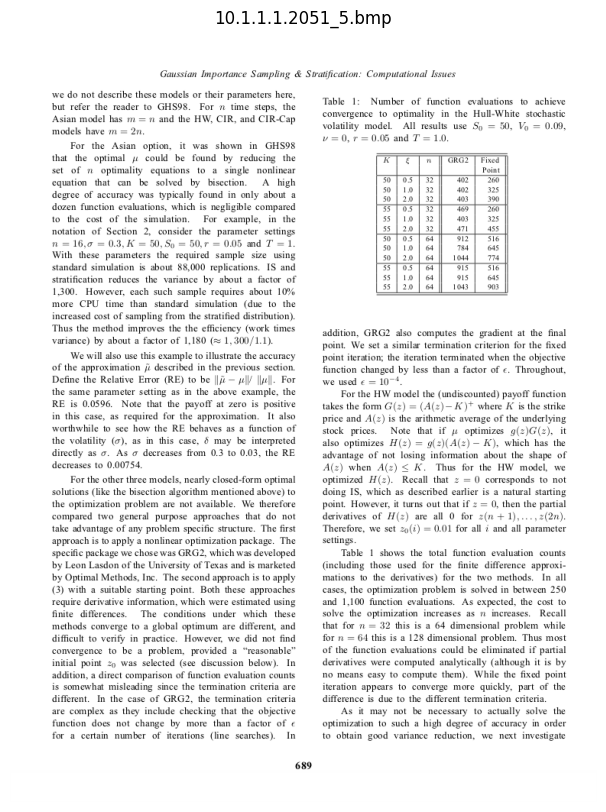

In [11]:
# checking a random positive .bmp file

r = np.random.randint(len(bmp_files))

img_filepath = os.path.join(english_data_dir, 'Positive', 'Raw', bmp_files[r])
img = cv2.imread(img_filepath, cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title(bmp_files[r])
plt.imshow(img)
plt.show()

In [12]:
# checking the corresponding .xml annotation
# Ref: https://stackabuse.com/reading-and-writing-xml-files-in-python/
# Ref: https://stackoverflow.com/questions/52824584/do-anyone-know-how-to-extract-image-coordinate-from-marmot-dataset

def hex2double(hexcode):
    """
    This function takes a 16 digit hexadecimal representation and
    convert it into its equivalent floating point form
    """
    return struct.unpack('!d', bytes.fromhex(hexcode))[0]

xml_fpath = img_filepath.replace('Raw', 'Labeled').replace('bmp', 'xml')
xml_file = eltree.parse(xml_fpath)
root = xml_file.getroot()
left, bottom, right, top = (hex2double(i) for i in root.get('CropBox').split())
pa_width = np.abs(left - right)
pa_height = np.abs(top - bottom)

bounding_boxes = []

height, width, _ = img.shape


for each_table_comp in xml_file.findall(".//Composite[@Label='Table']"):
    t_left, t_bottom, t_right, t_top = [hex2double(i) for i in each_table_comp.get('BBox').split()]
    
    t_left = width/pa_width * np.abs(t_left - left) 
    t_right = width/pa_width * np.abs(t_right - left)
    t_bottom = height/pa_height * np.abs(t_bottom - bottom) 
    t_top = height/pa_height * np.abs(t_top - bottom)
    bounding_boxes.append([t_left, t_top, t_right, t_bottom])

In [13]:
def crop_table(image_path, list_of_bboxes):
    fig = plt.figure(figsize=(20,10))
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    i = 1
    for each_bbox in list_of_bboxes:
        ax = fig.add_subplot(len(list_of_bboxes), 1, i)
        left, top, right, bottom = (int(i) for i in each_bbox)
        table_image = image[bottom:top, left:right]
        plt.axis('off')
        plt.imshow(table_image)
        i = i+1
    return None

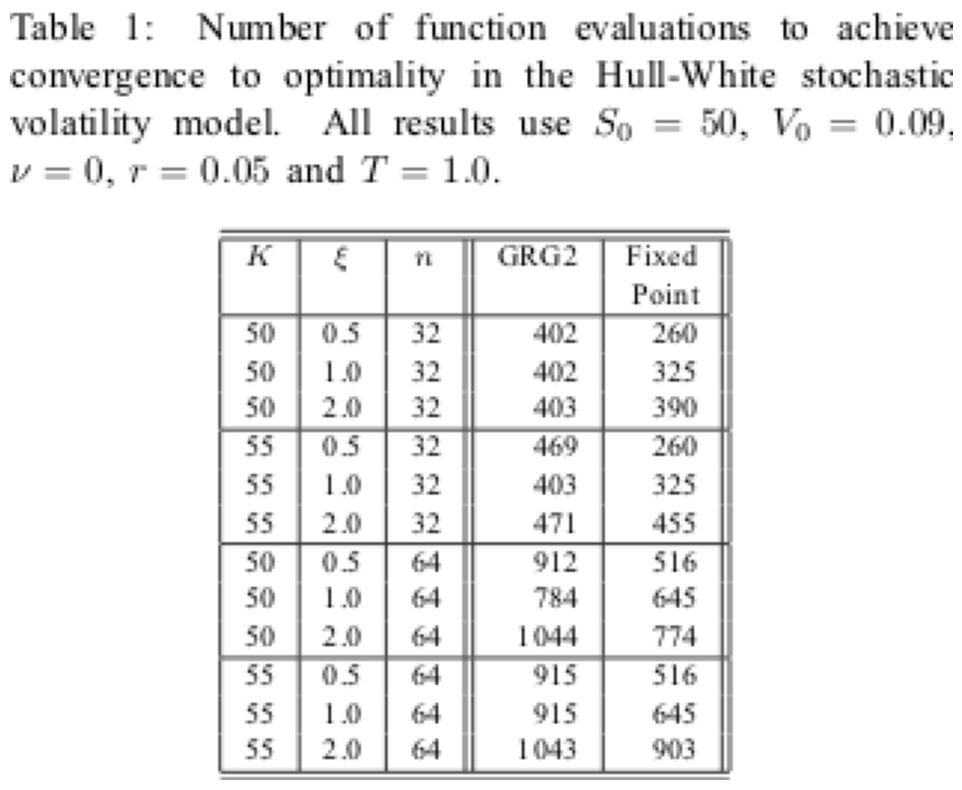

In [14]:
crop_table(img_filepath, bounding_boxes)

In [15]:
data_dir = os.path.join('data', 'C:\\Users\\AkshayPatil\\Desktop\\Falcon\\PDF_OCR\\dataset\\marmot_extended')
print("Total number of files in the directory : ", len(os.listdir(data_dir)))
print("Few contents of the directory : ")
os.listdir(data_dir)[0:5]

Total number of files in the directory :  1004
Few contents of the directory : 


['10.1.1.1.2006_3.bmp',
 '10.1.1.1.2006_3.xml',
 '10.1.1.1.2010_5.bmp',
 '10.1.1.1.2013_63.bmp',
 '10.1.1.1.2013_63.xml']

In [16]:
bmp_files = [i for i in os.listdir(data_dir) if i.endswith('bmp')]
xml_files = [i for i in os.listdir(data_dir) if i.endswith('xml')]
print("Number of .bmp files : ", len(bmp_files))
print("Number of .xml files : ", len(xml_files))

Number of .bmp files :  509
Number of .xml files :  495


In [17]:
# random .xml file in the marmot_extended
r = np.random.randint(len(xml_files))

xml_file_path = os.path.join(data_dir, xml_files[r])
xml_file = eltree.parse(xml_file_path)

In [18]:
# trying to retrive image dimension
rt = xml_file.getroot()
int(rt.findall('size')[0].findall('width')[0].text), int(rt.findall('size')[0].findall('height')[0].text)

(816, 1056)

In [19]:
# checking the name of annotated objects
for ele in rt.findall('object'):
    print(ele.find('name').text)

column
column


In [20]:
# This function will take a list of file names (images) and create table mask and column mask for each file and store the image paths and dimension in a dataframe

def hex2double(hexcode):
    """
    Input: 16digit hexadecimal number
    Output: Equivalent floating point representation
    """
    return struct.unpack('!d', bytes.fromhex(hexcode))[0]


def return_bboxes_extended(xml):
    """
    Input: Annotated xml file of an image from the marmot extended dataset
    Output: Dimension of the image and the list of bounding boxes of table columns present in the image
    """
    xml_file = eltree.parse(xml)
    root = xml_file.getroot()
    bboxes = []
    width = int(rt.findall('size')[0].findall('width')[0].text)
    height = int(rt.findall('size')[0].findall('height')[0].text)
    for ele in root.findall('object'):
        if ele.find('name').text == 'column':
            bbox = ele.find('bndbox')
            left = int(bbox.find('xmin').text)
            right = int(bbox.find('xmax').text)
            top = int(bbox.find('ymin').text)
            bottom = int(bbox.find('ymax').text)
        bboxes.append([left, top, right, bottom])
    return width, height, bboxes


def return_bboxes_v1(xml, width, height):
    """
    Input: Annotated xml file of an image from the marmot v1.0 dataset
    Output: The list of bounding boxes of tables present in the image
    """
    xml_file = eltree.parse(xml)
    root = xml_file.getroot()
    left, bottom, right, top = (hex2double(i) for i in root.get('CropBox').split())
    pa_width = np.abs(left - right)
    pa_height = np.abs(top - bottom)
    bboxes = []
    for each_table_comp in xml_file.findall(".//Composite[@Label='Table']"):
        t_left, t_bottom, t_right, t_top = [hex2double(i) for i in each_table_comp.get('BBox').split()]
        t_left = int(width/pa_width * np.abs(t_left - left))
        t_right = int(width/pa_width * np.abs(t_right - left))
        t_bottom = int(height/pa_height * np.abs(t_bottom - bottom)) 
        t_top = int(height/pa_height * np.abs(t_top - bottom))
        bboxes.append([t_left, t_top, t_right, t_bottom])
    return bboxes


def create_mask(img_path, list_of_bboxes, dim, mode='table'):
    """
    Input: Image, its corresponding list of bounding boxes, dimension of the image 
    and mode specifying the annotation type (table/column)
    Output: Create corresponding mask image (containing the boxes) and return the mask file path
    """
    data_dir = os.path.join('data', 'marmot_masked')
    image_dir = os.path.join(data_dir, 'images')
    mask_dir = os.path.join(data_dir, 'masks', mode)
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    if not os.path.exists(mask_dir):
        os.makedirs(mask_dir)
    fname = img_path.split(os.path.sep)[-1].replace('bmp', 'png')
    dest = os.path.join(image_dir, fname)
    if mode == 'table':
        img = Image.open(img_path)
        img.save(dest, 'png')
    image = Image.new("RGB", dim)
    mask = ImageDraw.Draw(image)
    for each_list in list_of_bboxes:
        mask.rectangle(each_list, fill=255)
    mask_fn = os.path.join(mask_dir, fname)
    image = np.array(image)
    image = Image.fromarray(image[:,:,0])
    image.save(mask_fn)
    if mode == 'table':
        return dest, mask_fn  
    return mask_fn


def compute_masks():
    """
    Returns a pandas dataframe containing the imagepath and mask_path and dimension.
    It invokes the above two methods to create corresponding mask images
    """
    images_dir = os.path.join('data', 'C:\\Users\\AkshayPatil\\Desktop\\Falcon\\PDF_OCR\\dataset\\marmot_extended')
    img_file_list = [i for i in os.listdir(images_dir) if i.endswith('bmp')]
    img_df = pd.DataFrame(columns=['image_path', 'image_dim', 'tablemask_path', 'columnmask_path'])
    for each_image in tqdm(img_file_list):
        img_path = os.path.join(images_dir, each_image)
        table_annot = os.path.join('data', 'C:\\Users\\AkshayPatil\\Desktop\\Falcon\\PDF_OCR\\dataset\\marmot_dataset_v1.0', 'data', 'English', 'Positive', 'Labeled', each_image.replace('bmp', 'xml'))
        column_annot = img_path.replace('bmp', 'xml')
        if not os.path.exists(column_annot):
            continue
        width, height, column_bboxes = return_bboxes_extended(column_annot)
        dim = (width, height)
        table_bboxes = return_bboxes_v1(table_annot, width, height)
        image_path, table_mask_path = create_mask(img_path, table_bboxes, dim, mode='table')
        column_mask_path = create_mask(img_path, column_bboxes, dim, mode='column')
        img_df.loc[len(img_df.index)] = [image_path, dim, table_mask_path, column_mask_path]
        csv_fname = os.path.join('data', 'marmot_masked', 'data.csv')
        img_df.to_csv(csv_fname, index=False)
    return img_df

In [21]:
img_df = compute_masks()

100%|████████████████████████████████████████████████████████████████████████████████| 509/509 [00:49<00:00, 10.36it/s]


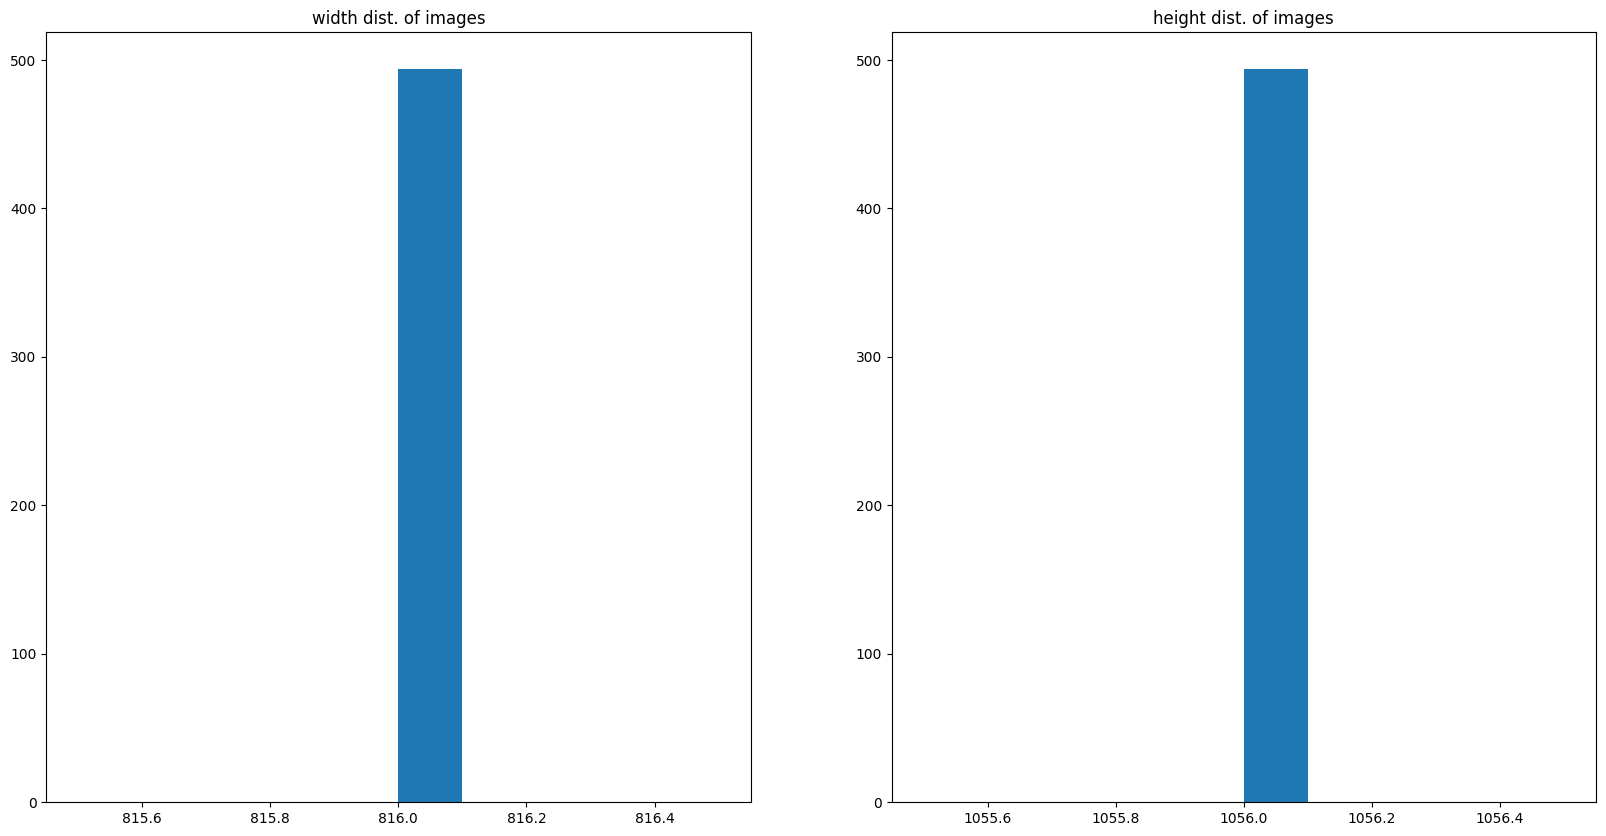

In [22]:
width_list = [i[0] for i in img_df['image_dim'].values]
height_list = [i[1] for i in img_df['image_dim'].values]

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.hist(width_list)
plt.title('width dist. of images')
plt.subplot(1,2,2)
plt.hist(height_list)
plt.title('height dist. of images')
plt.show()

In [23]:
data_dir = os.path.join('data', 'C:\\Users\\AkshayPatil\\Desktop\\Falcon\\PDF_OCR\\dataset\\TableTrainNet-master\\TableTrainNet-master\\dataset')
os.listdir(data_dir)

['Annotations',
 'common_func.py',
 'data.csv',
 'data_structure.py',
 'draw_img.py',
 'generate_database_csv.py',
 'Images',
 'img_to_jpeg.py',
 'other']

In [24]:
print('Number of images : ', len(os.listdir(os.path.join(data_dir, 'Images'))))
print('Number of annotation files : ', len(os.listdir(os.path.join(data_dir, 'Annotations'))))

Number of images :  1600
Number of annotation files :  1600


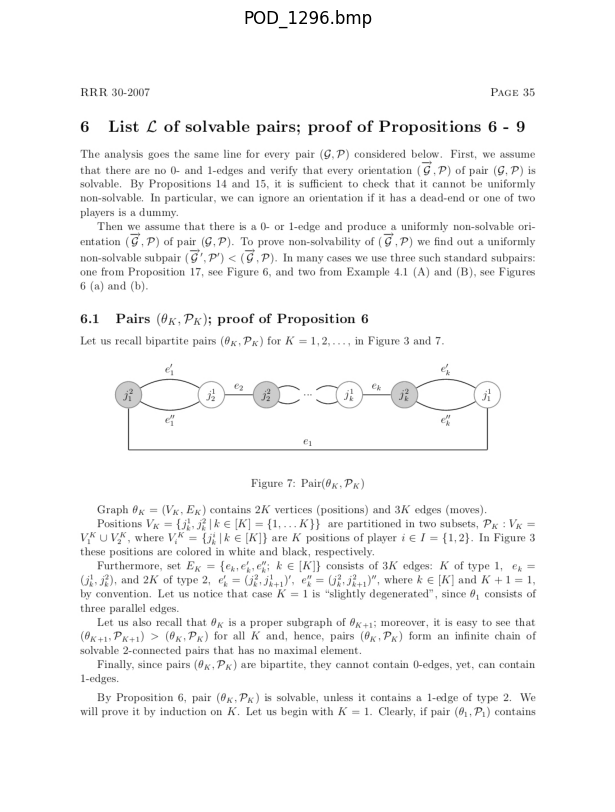

In [25]:
bmp_files = os.listdir(os.path.join(data_dir, 'Images'))

r = np.random.randint(len(bmp_files))

img_filepath = os.path.join(data_dir, 'Images', bmp_files[r])
img = cv2.imread(img_filepath, cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title(bmp_files[r])
plt.imshow(img)
plt.show()

In [26]:
xml_files = os.listdir(os.path.join(data_dir, 'Annotations'))

xml_file_path = os.path.join(data_dir, 'Annotations', xml_files[r])
xml_file = minidom.parse(xml_file_path)
print(xml_file.toprettyxml())

<?xml version="1.0" ?>
<document filename="POD_1296.xml">
	
	
	<figureRegion>
		
		
		<Coords points="186,591 873,591 186,745 873,745"/>
		
	
	</figureRegion>
	

</document>



In [27]:
def create_mask(img_path, list_of_bboxes, dim):
    """
    Input: takes a image path and list of bounding boxes to create corresponding mask image
    for ICDAR 2017 data
    Output: returns the file name of the mask file
    """
    data_dir = os.path.join('data', 'ICDAR 2017')
    image_dir = os.path.join(data_dir, 'table_images')
    mask_dir = os.path.join(data_dir, 'table_masks')
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    if not os.path.exists(mask_dir):
        os.makedirs(mask_dir)
    fname = img_path.split(os.path.sep)[-1].replace('bmp', 'png')
    dest = os.path.join(image_dir, fname)
    img = Image.open(img_path)
    img.save(dest, 'png')
    image = Image.new("RGB", dim)
    mask = ImageDraw.Draw(image)
    for each_list in list_of_bboxes:
        mask.rectangle(each_list, fill=255)
    mask_fn = os.path.join(mask_dir, fname)
    image = np.array(image)
    image = Image.fromarray(image[:,:,0])
    image.save(mask_fn) 
    return mask_fn


def compute_masks():
    """
    Returns a pandas dataframe containing the imagepath and mask_path and dimension.
    It invokes the above method to create corresponding mask images
    """
    img_df = pd.DataFrame(columns=['image_path', 'image_dim', 'mask_path'])
    images_dir = os.path.join('data', 'C:\\Users\\AkshayPatil\\Desktop\\Falcon\\PDF_OCR\\dataset\\TableTrainNet-master\\TableTrainNet-master\\dataset', 'Images')
    annots_dir = os.path.join('data', 'C:\\Users\\AkshayPatil\\Desktop\\Falcon\\PDF_OCR\\dataset\\TableTrainNet-master\\TableTrainNet-master\\dataset', 'Annotations')
    xml_filelist = os.listdir(annots_dir)
    for each_xml in tqdm(xml_filelist):
        xml_path = os.path.join(annots_dir, each_xml)
        xml = eltree.parse(xml_path)
        root = xml.getroot()
        table_list = root.findall('tableRegion')
        if len(table_list)==0:
            continue
        else:
            vertex_list = []
            for each_table in table_list:
                cord_list = each_table.find('Coords').get('points')
                cord_list = cord_list.split()
                vertices = [tuple(int(i) for i in cord_list[0].split(',')), tuple(int(i) for i in cord_list[-1].split(','))]
                vertex_list.append(vertices)
            image_path = xml_path.replace('Annotations', 'Images').replace('xml', 'bmp')
            image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            height, width, _ = image.shape
            mask_path = create_mask(image_path, vertex_list, (width, height))

            img_df.loc[len(img_df.index)] = [image_path, (width, height), mask_path]
        csv_fname = os.path.join('data', 'C:\\Users\\AkshayPatil\\Desktop\\Falcon\\PDF_OCR\\dataset\\TableTrainNet-master\\TableTrainNet-master\\dataset', 'data.csv')
    img_df.to_csv(csv_fname, index=False)
    return img_df

In [28]:
img_df = compute_masks()

100%|██████████████████████████████████████████████████████████████████████████████| 1600/1600 [01:08<00:00, 23.51it/s]


In [29]:
print('Number of datapoints in ICDAR-2017 table extraction dataset : ', len(img_df))

Number of datapoints in ICDAR-2017 table extraction dataset :  549


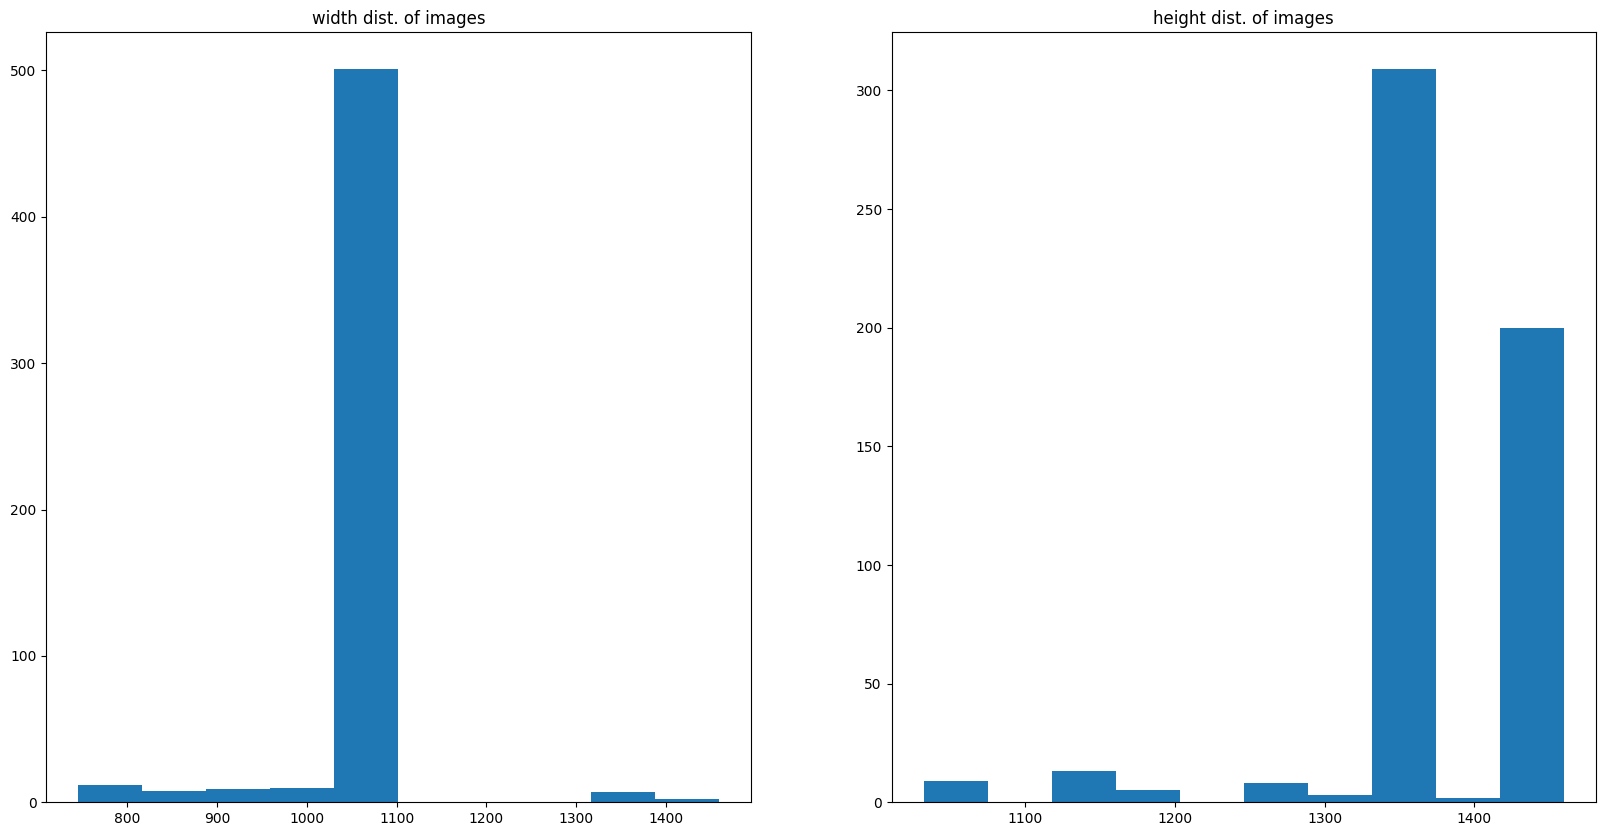

In [30]:
width_list = [i[0] for i in img_df['image_dim'].values]
height_list = [i[1] for i in img_df['image_dim'].values]

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.hist(width_list)
plt.title('width dist. of images')
plt.subplot(1,2,2)
plt.hist(height_list)
plt.title('height dist. of images')
plt.show()

2. Modeling

* Data definition

In [31]:
# defining data directory
tr_data_dir = os.path.join('data', 'marmot_masked')
train_df = pd.read_csv(os.path.join(tr_data_dir, 'data.csv'))

In [32]:
tf.keras.backend.clear_session()
dataset = tf.data.Dataset.from_tensor_slices((train_df['image_path'].values, train_df['tablemask_path'].values, train_df['columnmask_path'].values))

In [33]:
# defining function for loading the images into memory
# it will also perform resizing and normalizing at the time of loading 
def _parse_function(image, mask, colmask):
    dim = (512,512)
    image_decoded = tf.io.decode_png(tf.io.read_file(image), channels=3)
    image = tf.cast(image_decoded, tf.float32)
    image = tf.image.resize(image, dim)
    image = tf.cast(image, tf.float32) / 255.0
    
    mask_decoded = tf.io.decode_png(tf.io.read_file(mask), channels=1)
    mask = tf.cast(mask_decoded, tf.float32)
    mask = tf.image.resize(mask, dim)
    mask = tf.cast(mask, tf.float32) / 255.0

    colmask_decoded = tf.io.decode_png(tf.io.read_file(colmask), channels=1)
    colmask = tf.cast(colmask_decoded, tf.float32)
    colmask = tf.image.resize(colmask, dim)
    colmask = tf.cast(colmask, tf.float32) / 255.0
    
    mask_dict = {'table': mask, 'column': colmask}

    return image, mask_dict

In [34]:
DATA_SIZE = len(dataset)
VAL_SIZE = 0.1

VAL_LENGTH = int(VAL_SIZE*DATA_SIZE)
TRAIN_LENGTH = int((1-VAL_SIZE) * DATA_SIZE)

BATCH_SIZE = 1
BUFFER_SIZE = TRAIN_LENGTH

VAL_BUFFER_SIZE = VAL_LENGTH

VALIDATION_STEPS = VAL_LENGTH // BATCH_SIZE

STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [35]:
train = dataset.take(TRAIN_LENGTH)
val = dataset.skip(TRAIN_LENGTH)
train = train.map(_parse_function)
val = val.map(_parse_function)

In [36]:
train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val.shuffle(VAL_BUFFER_SIZE).batch(BATCH_SIZE)

In [37]:
# function to display a list of images
def visualize(image_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'Table Mask', 'Column Mask']
  for i in range(len(image_list)):
    plt.subplot(1, len(image_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image_list[i]))
    plt.axis('off')
  plt.show()

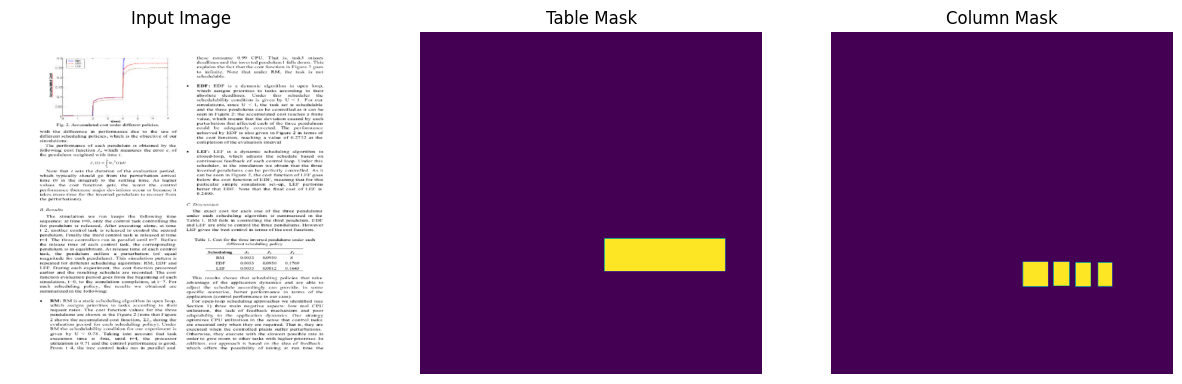

In [38]:
for image, mask  in train.take(1):
    #print(train.take(1))
    visualize([image, mask['table'], mask['column']])

* Model definition

In [39]:
class TableConvLayer(Layer):
    def __init__(self, name='table'):
        super().__init__(name=name)
        self.conv7 = Conv2D(512, (1,1), activation='relu', name='conv7table')
        self.upsample_conv7 = UpSampling2D((2,2))
        self.concat_p4 = Concatenate()
        self.upsample_p4 = UpSampling2D((2,2))

        self.concat_p3 = Concatenate()
        self.upsample_p3 = UpSampling2D((2,2))

        self.upsample_p3_2 = UpSampling2D((2,2))
        self.convtranspose = Conv2DTranspose(3, (3,3), strides=2, padding='same')

    def call(self, inputs):
        X, pool3, pool4 = inputs
        X = self.conv7(X)
        X = self.upsample_conv7(X)
        X = self.concat_p4([X, pool4])
        X = self.upsample_p4(X)
        X = self.concat_p3([X, pool3])
        X = self.upsample_p3(X)
        X = self.upsample_p3_2(X)
        X = self.convtranspose(X)

        return X


class ColumnConvLayer(Layer):
    def __init__(self, name='column'):
        super().__init__(name=name)
        self.conv7 = Conv2D(512, (1,1), activation='relu', name='conv7column')
        self.dropout = Dropout(0.8)
        self.conv8 = Conv2D(512, (1,1), activation='relu', name='conv8column')
        self.upsample_conv8 = UpSampling2D((2,2))
        self.concat_p4 = Concatenate()
        self.upsample_p4 = UpSampling2D((2,2))

        self.concat_p3 = Concatenate()
        self.upsample_p3 = UpSampling2D((2,2))

        self.upsample_p3_2 = UpSampling2D((2,2))
        self.convtranspose = Conv2DTranspose(3, (3,3), strides=2, padding='same')

    def call(self, inputs):
        X, pool3, pool4 = inputs
        X = self.conv7(X)
        X = self.dropout(X)
        X = self.conv8(X)
        X = self.upsample_conv8(X)
        X = self.concat_p4([X, pool4])
        X = self.upsample_p4(X)
        X = self.concat_p3([X, pool3])
        X = self.upsample_p3(X)
        X = self.upsample_p3_2(X)
        X = self.convtranspose(X)

        return X

In [40]:
def build_tablenet():
    tf.keras.backend.clear_session()
    input_shape = (512,512,3)

    base = VGG19(input_shape=input_shape, include_top=False, weights='imagenet')

    end_layers_list = ['block3_pool', 'block4_pool', 'block5_pool']
    end_layers = [base.get_layer(i).output for i in end_layers_list]

    X = Conv2D(512, (1,1), activation='relu', name='block6_conv1')(end_layers[-1])
    X = Dropout(0.8)(X)
    X = Conv2D(512, (1,1), activation='relu', name='block6_conv2')(X)
    X = Dropout(0.8)(X)
    
    table_branch = TableConvLayer()([X, end_layers[0], end_layers[1]])
    column_branch = ColumnConvLayer()([X, end_layers[0], end_layers[1]])

    model = Model(inputs=base.input, outputs=[table_branch, column_branch], name='TableNetVGG19')
    return model

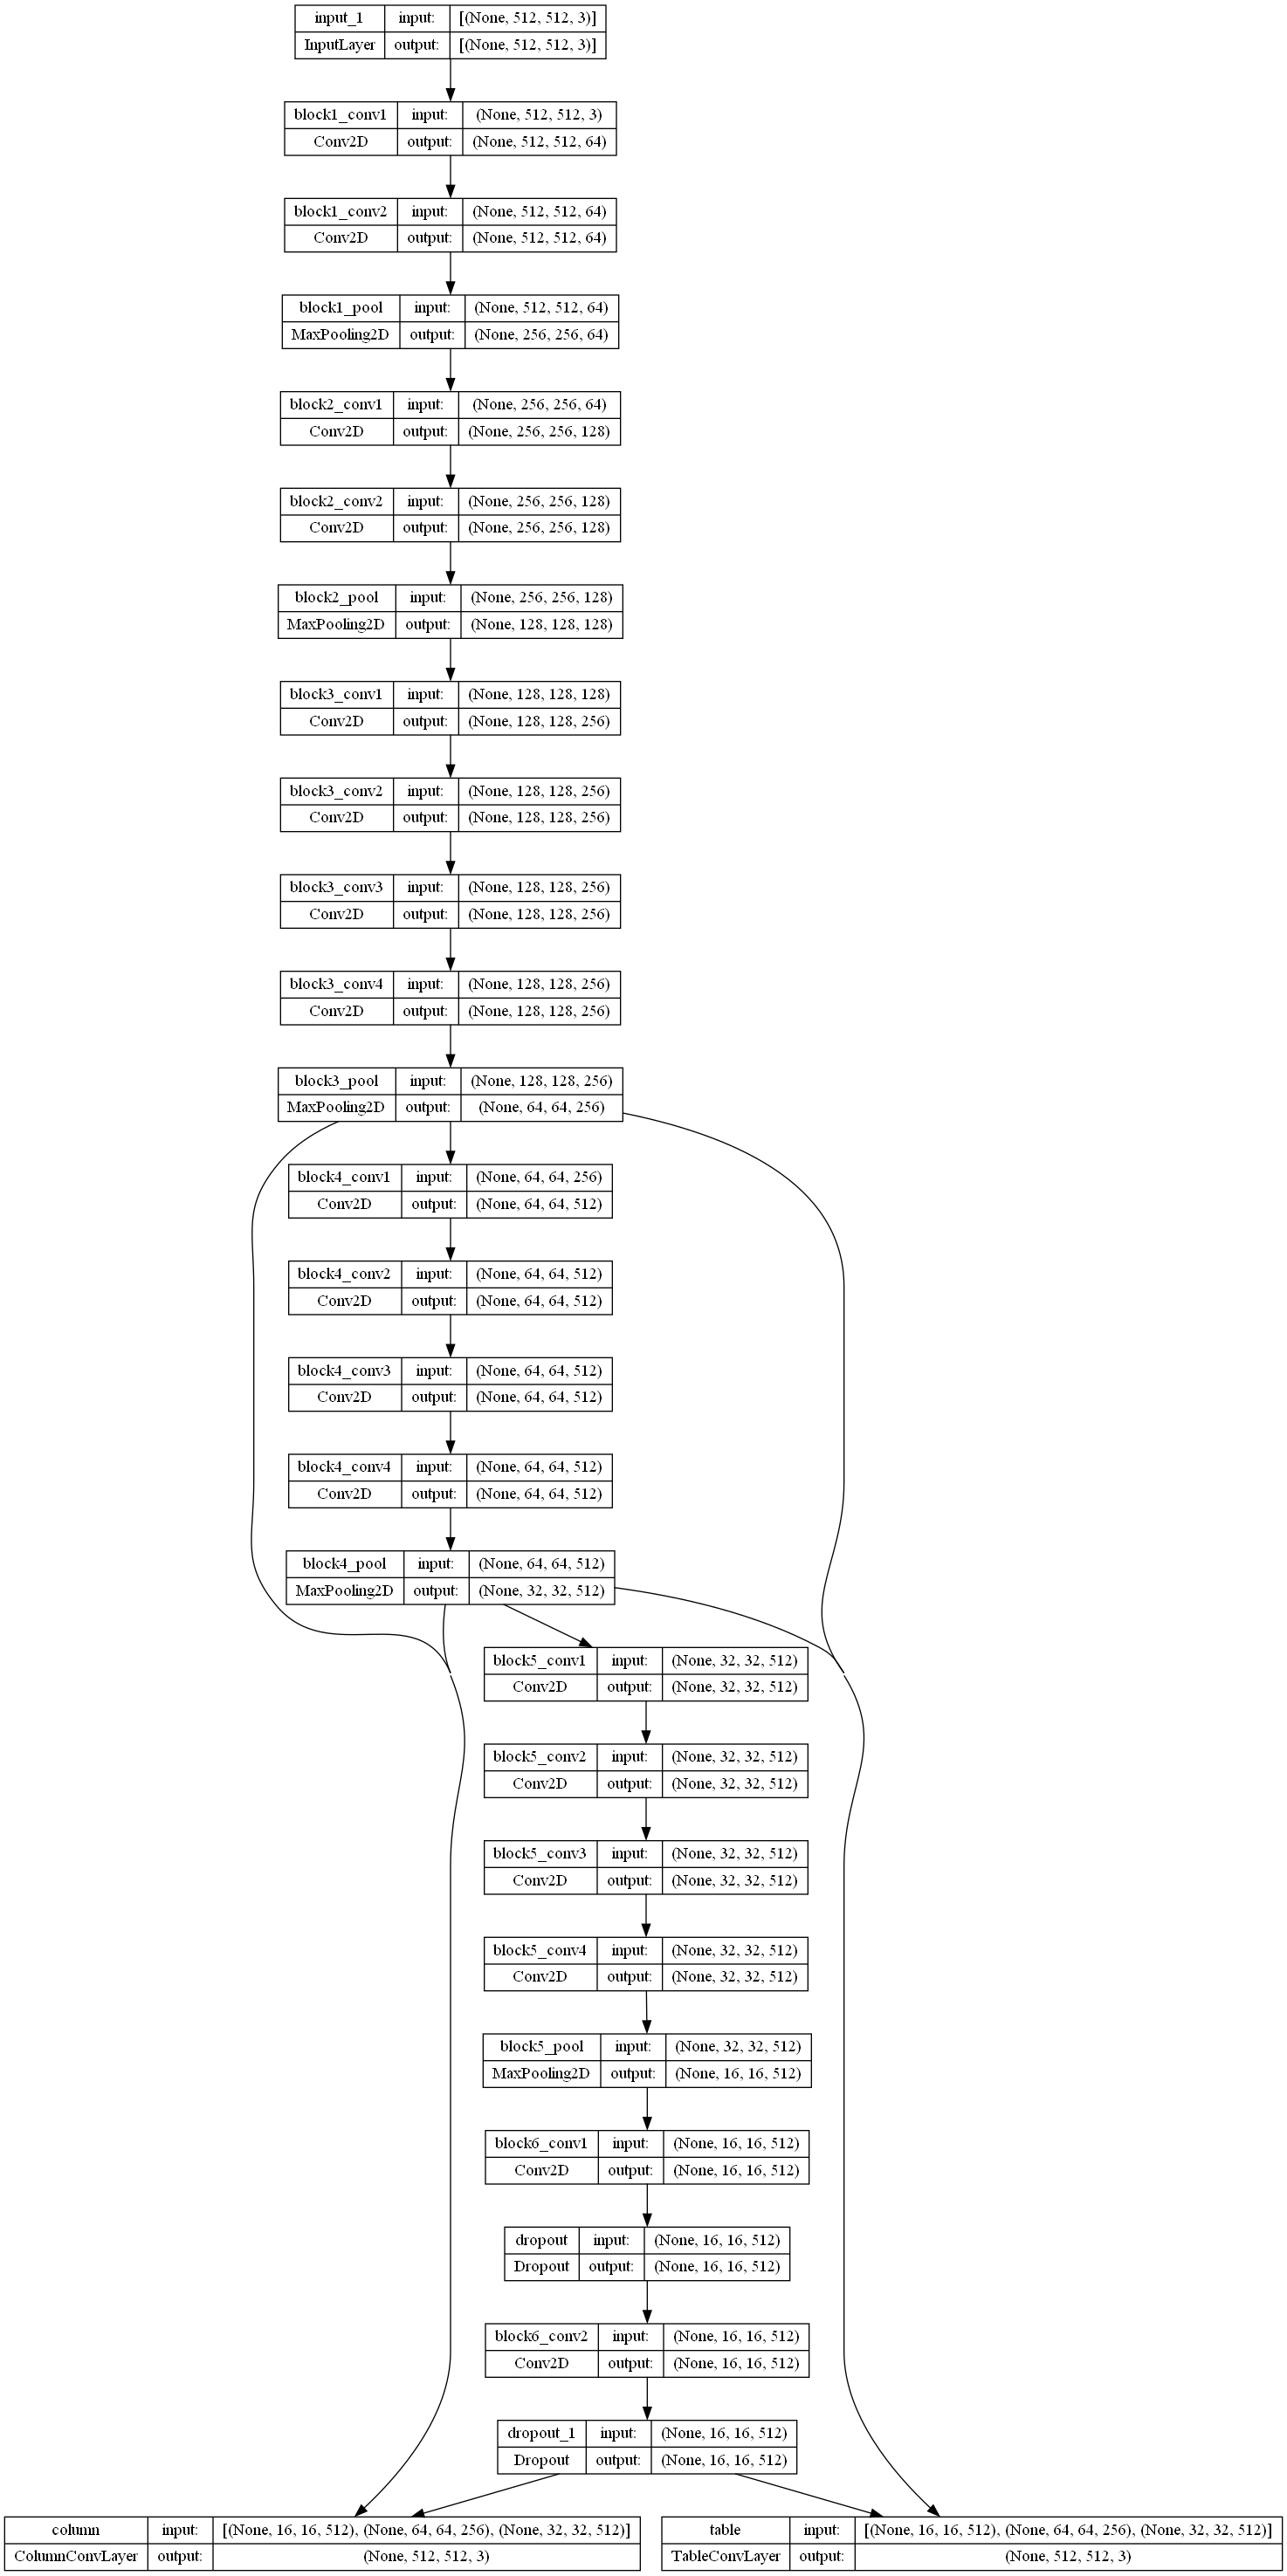

In [41]:
model = build_tablenet()
tf.keras.utils.plot_model(model,to_file='model_test.png',show_shapes=True,show_layer_names=True)

In [40]:
model.summary()

Model: "TableNetVGG19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                     

* Callback definition and model compilation

In [41]:
# Ref: https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/


losses = {
    "table": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "column": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

lossWeights = {"table": 1.0, "column": 1.0}
optim = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08)
sc_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='sc_accuracy')


model.compile(optimizer = optim,
              loss = losses,
              metrics = [sc_acc],
              loss_weights = lossWeights)

In [42]:
# visualizing initial predictions (without training)
def render(mask):
  mask = tf.argmax(mask, axis=-1)
  mask = mask[..., tf.newaxis]
  return mask[0]

1/1 [==============================] - 2s 2s/step


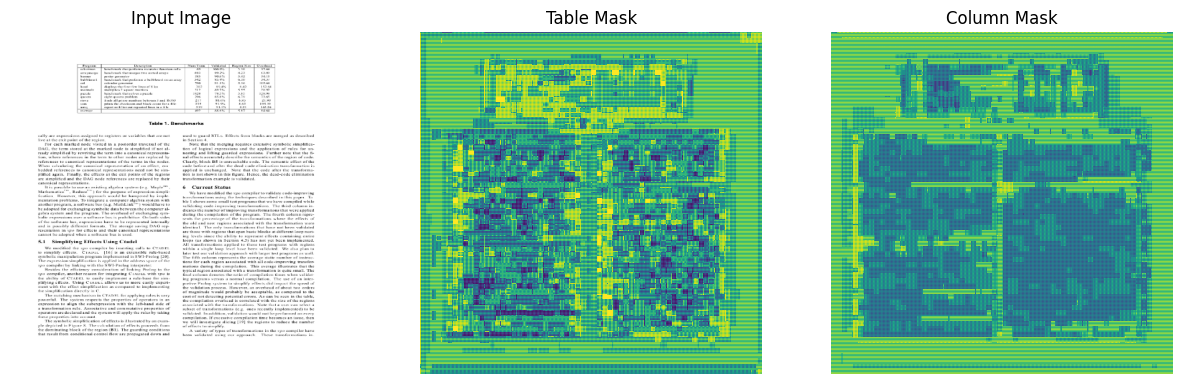

In [43]:
for image, masks in val_dataset.take(1):
    table_mask, column_mask = masks['table'], masks['column']

pred_tab_mask, pred_col_mask = model.predict(image)
visualize([image[0], render(pred_tab_mask), render(pred_col_mask)])

In [44]:
# defining model callbacks (checkpoint and tensorboard)
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

checkpoint_path = "tablenet_weights/cp_{epoch:04d}_{val_loss:.4f}.ckpt" 
checkpoint_dir = os.path.dirname(checkpoint_path)

log_dir = "tablenet_logs"

if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

cp_callback = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True, monitor='val_loss', save_weights_only=True)

tb_callback = TensorBoard(log_dir)


callbacks = [cp_callback, tb_callback]

* Model training

In [46]:
model.fit(
    train_dataset, epochs=10,
    steps_per_epoch= STEPS_PER_EPOCH,
    validation_data=val_dataset,
    validation_steps= VALIDATION_STEPS,
    callbacks=callbacks
)

444/444 [==============================] - ETA: 0s - loss: 0.6223 - table_loss: 0.3362 - column_loss: 0.2861 - table_sc_accuracy: 0.8712 - column_sc_accuracy: 0.8899
Epoch 1: val_loss improved from inf to 0.48435, saving model to tablenet_weights\cp_0001_0.4843.ckpt
444/444 [==============================] - 1996s 4s/step - loss: 0.6223 - table_loss: 0.3362 - column_loss: 0.2861 - table_sc_accuracy: 0.8712 - column_sc_accuracy: 0.8899 - val_loss: 0.4843 - val_table_loss: 0.2566 - val_column_loss: 0.2278 - val_table_sc_accuracy: 0.8928 - val_column_sc_accuracy: 0.9017


3. Extracting table

In [48]:
model_path = 'C:\\Users\\AkshayPatil\\Desktop\\Falcon\\PDF_OCR'
if not os.path.exists(model_path):
    os.makedirs(model_path)

model.save(model_path)

INFO:tensorflow:Assets written to: C:\Users\AkshayPatil\Desktop\Falcon\PDF_OCR\assets


INFO:tensorflow:Assets written to: C:\Users\AkshayPatil\Desktop\Falcon\PDF_OCR\assets


In [49]:
# loading trained model
model = build_tablenet()
latest_cp = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest_cp)

In [50]:
pytesseract.pytesseract.tesseract_cmd = "C:\\Program Files\\Tesseract-OCR\\tesseract.exe"

def extract_table(image_fname):
    image_orig = Image.open(image_fname)
    original_dim = image_orig.size
    image = image_orig.resize((512,512))
    np_image = np.asarray(image)/255.0
    tab_mask, _ = model.predict(np.expand_dims(np_image, axis=0))
    
    tab_mask = np.squeeze(render(tab_mask).numpy())

    tab_mask = Image.fromarray(np.uint8(tab_mask))
    tab_mask = tab_mask.resize(original_dim)

    tab_mask = np.array(tab_mask)

    kernel_erode = np.ones((20,20), np.uint8)
    kernel = np.ones((50,50), np.uint8)
    
    tab_mask =cv2.erode(tab_mask, kernel_erode, iterations=2)


    tab_mask = cv2.morphologyEx(tab_mask, cv2.MORPH_OPEN, kernel)
    tab_mask = cv2.morphologyEx(tab_mask, cv2.MORPH_CLOSE, kernel)

    image_orig = np.array(image_orig)
    masked = cv2.bitwise_and(image_orig, image_orig, mask=tab_mask)
    # Ref: https://stackoverflow.com/questions/62813546/how-do-i-crop-an-image-based-on-custom-mask-in-python
    # transparent cropp
    tmp = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
    _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
    b, g, r = cv2.split(masked)
    rgba = [b,g,r, alpha]
    masked = cv2.merge(rgba,4)
    text = pytesseract.image_to_string(masked)
    print(text)
    plt.figure(figsize=(15,20))
    plt.axis('off')
    plt.imshow(masked)
    plt.show()

C:\Users\AkshayPatil\Desktop\Falcon\PDF_OCR\Img\Page_1.jpg
1/1 [==============================] - 1s 1s/step
rint <a Download CSV
a ite

 

St Louis , Mo

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

“IREAND ALLIED Policy: 84SBAUH9426 Policy Term: 06/24/2047 - 06/24/2018
vo Claims for this po icy EE
"IREANDALLIED Policy: 84SBAUH9426 Policy Term: 06/21/2048 - 06/21/2019 ——
Jo Claims for this policy OE
“IREAND ALLIED Policy: 458A UHS426 ~ Policy Term: 06/21/2019 - 06/21/2020

loClaimsforthispolicy #3 = =

>REMISES/OPERATIONS Policy: 84SBAUH9426 Policy Term: 06/21/2017-o8/212018

o Claims for this polic

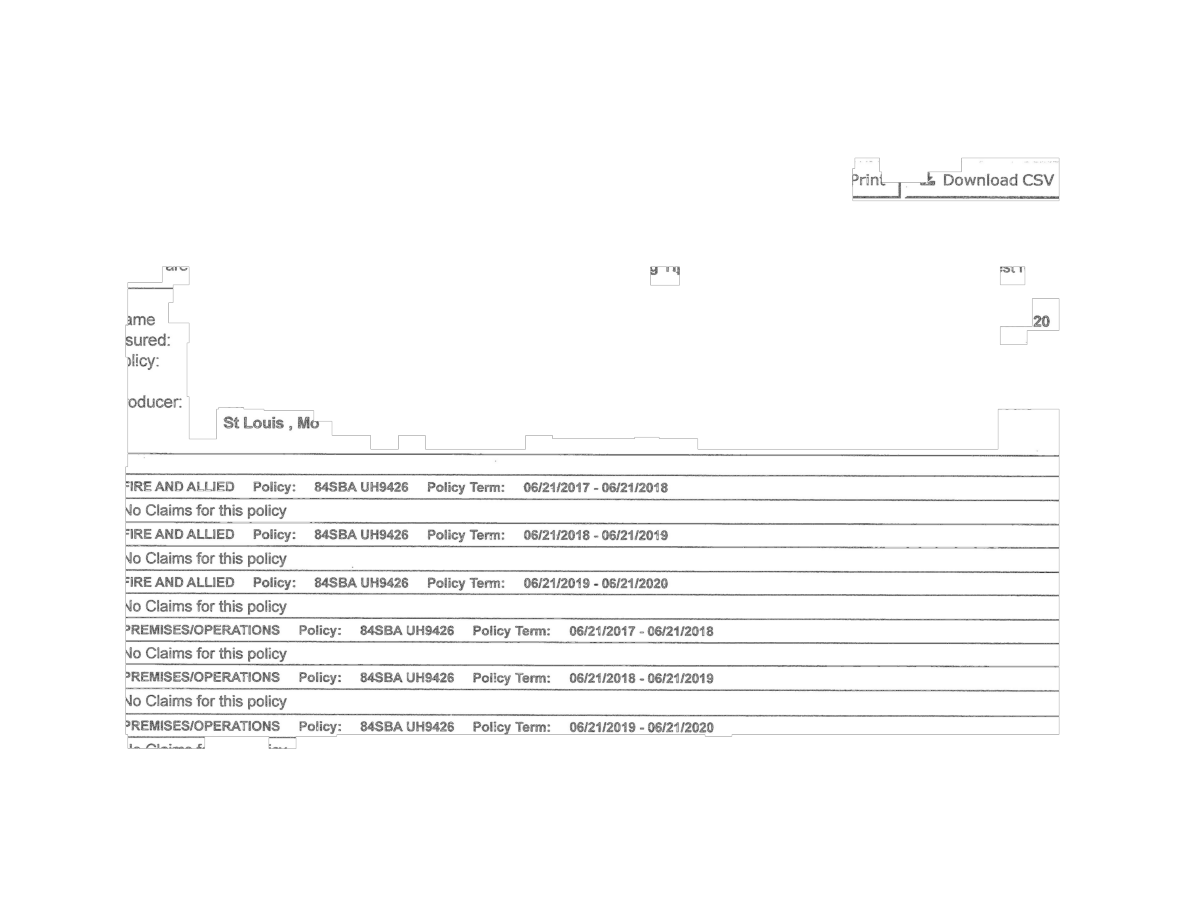

In [51]:
img_fname = 'C:\\Users\\AkshayPatil\\Desktop\\Falcon\\PDF_OCR\\Img\\Page_1.jpg'
print(img_fname)
extract_table(img_fname)